**Introduction to Graph data**

Graphs can be seen as a system or language for modeling systems that are complex and linked together.
A graph is a data type that is modelled as a set of objects which can be represented as a node or vertex and their relationships which is called edges. A graph data can also be seen as a network data where there are points connected together. 

**A node(vertex)** of a graph is point in a graph while **an edge** is a component that joins edges together in a graph. Graphs can be used to represent data from a lot of domains like biology, physics, social science, chemistry and others.

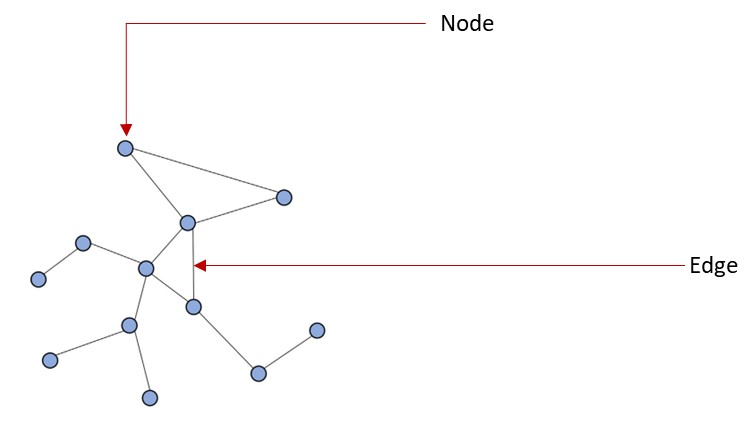






**Graph classification**

Graphs can be classified into different categories **directed/undirected graphs**, **weighted/binary graphs** and **homogenous/heterogenous graphs**.



*   **Directed/Undirected graphs**: Directed graphs are the ones that all the edges have directtions while in undirected graphs, the edges are does not have directions
*   **Weighted/Binary graphs**: Weighted graphs is a type of graph that each of the edges are assigned with a value while binary graphs are the ones that the edges does not have an assigned value.
*   **Homogenous/Heterogenous graphs**: Homogenous graphs are the ones that all the nodes and/or edges are of the same type (e.g. friendship graph) while heterogenous graphs are graphs where the nodes and/or edges are of different types (e.g. knowledge graph).


**Traditional graph analysis** methods requires using searching algorithms, clustering spanning tree algorithms and so on. A major downside to using these methods for analysis of graph data is that you require a prior knowledge of the graph to be able to apply these algorithms.

Based on the structure of the graph data, traditional machine learning system will not be able to properly interprete the graph data and thus the advent of the **Graph Neural Network (GNN)**. Graph neural network is a domain of deep learning that is mostly concerned with deep learning operations on graph datasets.

**Application of Machine learning in Graphs**

1. Protein folding for drug analysis
2. Recommender systems
3. Drug side effect prediction
4. Traffic predictions
5. Drug discovery
6. Molecule generation
7. Physics simulation



**Exploring graph with Pytorch Geometric**

In this notebook we will explore graph and graph neural network using PyTorch Geometric (PyG). We will start by importing and installing the needed packages.

In [17]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#ensure that the PyTorch and the PyG are the same version
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

2.5.1+cpu


We will now create a function that will help us visualize a graph data.

In [18]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

Graph dataset

PyG provides access to a couple of graph datasets. For this notebook, we are going to use that Zachary's karate club network

In [19]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [25]:
Data_karate = pd.DataFrame(dataset)
Data_karate = pd.DataFrame(dataset.edge_index)
Data_karate
#len(Data_karate)

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,155
0,0,0,0,0,0,0,0,0,0,0,...,33,33,33,33,33,33,33,33,33,33
1,1,2,3,4,5,6,7,8,10,11,...,20,22,23,26,27,28,29,30,31,32


Now that we have imported a graph dataset, let's look at some of the properties of a graph dataset. We will look at some of the properties at the level of the dataset and then select a graph in the dataset to explore it's properties.

In [6]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Now let's visualize the graph using the function that we created earlier. But first, we will convert the graph to networkx graph

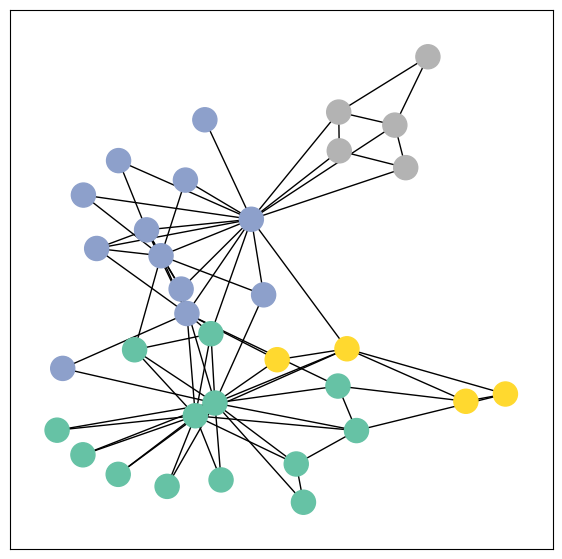

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

**Implementing a Graph Neural Network**

For this notebook, we will use a simple GNN which is the Graph Convolution Network (GCN) layer. Our GNN is defined by stacking three graph convolution layers, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away). In addition, the GCNConv layers reduce the node feature dimensionality to  2 , i.e.,  34→4→4→2 . Each GCNConv layer is enhanced by a tanh non-linearity. We then apply a linear layer  which acts as a classifier to map the nodes to 1 out of the 4 possible classes

In [8]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


**Training of the Network Model**

To train the network, we will use the **CrossEntropyLoss** for the loss function and **Adam** as the gradient optimizer

In [30]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    #print(out)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, out, h

h_values = []
loss_values = []
epoch_no = []
output_values = []

for epoch in range(401):
    loss, out, h = train(data)
    h_values.append(h.detach())
    loss_values.append(loss.detach())
    output_values.append(out.detach())
    epoch_no.append(epoch)
    #print(f'Epoch: {epoch}, Loss: {loss}')
   

For more information about PyTorch Geometric 
https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

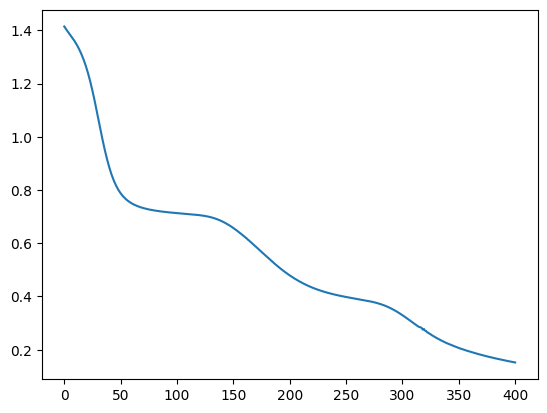

In [31]:
plt.plot(epoch_no, loss_values)
plt.show()

In [32]:
h_values[-1]
# plt.plot(epoch_no, h_values)
# plt.show()

tensor([[-0.0910, -0.9990],
        [ 0.9337, -1.0000],
        [ 0.4843, -0.9997],
        [ 0.9163, -0.9999],
        [-1.0000,  0.9942],
        [-1.0000,  0.9991],
        [-1.0000,  0.9991],
        [ 0.4767, -0.9990],
        [-0.9944, -0.5157],
        [-0.9393, -0.9279],
        [-1.0000,  0.9942],
        [-0.2698, -0.9933],
        [ 0.4274, -0.9983],
        [-0.2440, -0.9961],
        [-0.9985,  0.5221],
        [-0.9983,  0.4697],
        [-1.0000,  0.9985],
        [-0.1130, -0.9960],
        [-0.9987,  0.6168],
        [-0.8356, -0.9701],
        [-0.9984,  0.5070],
        [-0.0985, -0.9961],
        [-0.9983,  0.4801],
        [-0.2681, -0.9947],
        [ 0.9968, -1.0000],
        [ 0.9929, -1.0000],
        [-0.9974, -0.0866],
        [ 0.8231, -0.9996],
        [ 0.0136, -0.9968],
        [-0.9944, -0.4985],
        [-0.9912, -0.6088],
        [ 0.6134, -0.9991],
        [-0.9996, -0.1258],
        [-0.9958, -0.9382]])

In [33]:
output_values[-1]

tensor([[ 1.1116,  3.0403,  1.1689, -3.0990],
        [-2.2882,  3.3424,  5.0485, -5.6508],
        [-0.7971,  3.2103,  3.3474, -4.5324],
        [-2.2304,  3.3372,  4.9825, -5.6072],
        [ 3.1441, -1.2945, -4.5854,  6.1940],
        [ 3.1418, -1.3046, -4.5913,  6.2114],
        [ 3.1418, -1.3046, -4.5912,  6.2114],
        [-0.7723,  3.2067,  3.3178, -4.5111],
        [ 3.8707,  1.7893, -2.8112,  0.8525],
        [ 3.8910,  2.6469, -2.1238, -0.7392],
        [ 3.1441, -1.2945, -4.5854,  6.1940],
        [ 1.7021,  2.9764,  0.4856, -2.6344],
        [-0.6090,  3.1908,  3.1303, -4.3859],
        [ 1.6179,  2.9897,  0.5865, -2.7085],
        [ 3.3721, -0.3304, -4.0316,  4.5245],
        [ 3.3974, -0.2234, -3.9701,  4.3392],
        [ 3.1420, -1.3033, -4.5905,  6.2091],
        [ 1.1829,  3.0277,  1.0824, -3.0339],
        [ 3.3262, -0.5239, -4.1426,  4.8594],
        [ 3.5679,  2.7634, -1.6824, -1.1459],
        [ 3.3793, -0.2995, -4.0139,  4.4710],
        [ 1.1350,  3.0323,  1.1373